In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
import seaborn as sns
import pandas_datareader as web
import datetime as dt
import pandas_ta as ta
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Flatten
from tensorflow.keras.models import Sequential
from keras.models import load_model
from sklearn import preprocessing

from tensorflow.python.keras import Input


import random
random.seed(42)
import numpy
numpy.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)





def get_X_Y(input_dataset_directory, columns_to_remove, what_is_Y, is_correlation, percentage_of_correlation, remove):
    
    data = pd.read_csv(input_dataset_directory)
    # data = data[data.date <  '2021-11-21 07:30:00+03:30']

    data=data.dropna()
    data = data.reset_index(drop=True)
    try:
        data = data.drop(['Unnamed: 0'] , axis =1)
    except:
        print('dataset does not have Unnamed column')

    data.sort_values(by=['date'],ascending=[True],inplace=True)


    original_data = data.copy()
    data = data.drop(columns_to_remove , axis =1)
    
    if is_correlation :
        
        corr_features = correlation(data, percentage_of_correlation)
        for i in remove:
            if i in corr_features:
                corr_features.remove(i)
    
        data = data.drop(corr_features,axis=1)

    Y = data[what_is_Y]
    X = data.copy()
    X = X.iloc[: , :].values
    Y = Y.iloc[: , :].values
    return X, Y, data

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

def show_correlation_matrix(data):
    from matplotlib.pyplot import figure
    figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
    plt.show()

def split_data_set(X, Y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, shuffle = False)
    X_test= np.append(X_train[len(X_train)-time_steps:], X_test , axis=0)    
    y_test= np.append(y_train[len(y_train)-time_steps:], y_test , axis=0)        
    return X_train, X_test, y_train, y_test

def create_dataset(X, y, time_steps=1, look_ahead = 0):
    Xs, ys , yla = [], [], []
    for i in range(len(X) - time_steps - look_ahead):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps,:])
        yla.append(y[i + time_steps + look_ahead,:])
        # yla.append(y[i + time_steps : i + time_steps + look_ahead + 1])
    return np.array(Xs), np.array(ys), np.array(yla)

def get_scalers(X_train, X_test, y_train, y_test, X_range, Y_range):

    f_transformer = preprocessing.MinMaxScaler((-X_range, X_range))

    f_transformer = f_transformer.fit(X_train)
    X_train = f_transformer.transform(X_train)
    X_test = f_transformer.transform(X_test)

    cnt_transformer = preprocessing.MinMaxScaler((-Y_range, Y_range))
    cnt_transformer = cnt_transformer.fit(y_train)
    y_train = cnt_transformer.transform(y_train)
    y_test = cnt_transformer.transform(y_test)
    
    return X_train, X_test, y_train, y_test, f_transformer, cnt_transformer

def train_model(GRU_unit, dense_unit, optimizer, early_stopping_patience, batch_size, epochs, verbose, X_train_f, X_test_f, y_test_f, y_train_f , save = False, load = False , path = 'test'  ):
    if load == False :
        model = Sequential()
        model.add(GRU(GRU_unit, return_sequences=False, activation = 'tanh', input_shape = (X_train_f.shape[1], X_train_f.shape[2])))
        model.add(Dense(units = dense_unit ,activation='linear'))
        model.compile(loss='mse', optimizer = optimizer)
        model.summary()
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = early_stopping_patience)
    
        hist = model.fit(X_train_f, y_train_f, batch_size = batch_size, epochs = epochs, shuffle=False, verbose = verbose, validation_data = (X_test_f, y_test_f),callbacks=[es_callback])
        if save:
            model.save(path+".h5")
    else:
        model = load_model(path + '.h5')
        #TODO handle it
        hist = []
    return model, hist

def plot_loss_of_model(hist,path):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(path+'.jpg')
    
    
def validate_model(model, cnt_transformer, time_steps, X_train_f, X_test_f, y_test_f, y_train_f,path):
    print('----------------------------------------------------\n')
    print("*** SHAPES \n")
    print(X_train_f.shape, y_train_f.shape)
    print(X_test_f.shape, y_test_f.shape)
    print('Time step is :' + str(time_steps))
    y_pred = model.predict(X_test_f)

    y_test_inv = cnt_transformer.inverse_transform(y_test_f)
    y_pred_inv = cnt_transformer.inverse_transform(y_pred)

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import mean_squared_error

    results = model.evaluate(X_test_f, y_test_f)
    for i in range((np.shape(y_test_inv))[1]):
        print("mse: %s" % (mean_squared_error(y_test_inv[:,i], y_pred_inv[:,i])))
        with open(path+'result.txt', 'a') as f:
            f.write("\n mse for One candle test: %s" % (mean_squared_error(y_test_inv[:,i], y_pred_inv[:,i])))
    print(results)
    print('\n')
                  
    y_pred = model.predict(X_train_f)
    y_test_inv = cnt_transformer.inverse_transform(y_train_f)
    y_pred_inv = cnt_transformer.inverse_transform(y_pred)
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import mean_squared_error
    results = model.evaluate(X_train_f, y_train_f)
    for i in range((np.shape(y_test_inv))[1]):
        print("mse: %s" % (mean_squared_error(y_test_inv[:,i], y_pred_inv[:,i])))
        with open(path+'result.txt', 'a') as f:
            f.write("\n mse for train test: %s" % (mean_squared_error(y_test_inv[:,i], y_pred_inv[:,i])))
    print(results)
    print('----------------------------------------------------\n')

def change_value_next_value(X_test_look_ahead,i,j,predict,start,end):
    end = end + 1
    before = X_test_look_ahead[i,1:j,start : end]
    after = X_test_look_ahead[i,j+1:,start : end]
   
    before = before.reshape(-1)
    after = after.reshape(-1)
    
    #test to make sure
    predict = predict.reshape(-1)
   
    before = np.append(before, predict)
    before = np.append(before, after)
    
    before = before.reshape(time_steps, (end - start))
    
    X_test_look_ahead[i,:,start : end] = before
def create_future_value_array(X_test_f, look_ahead, start , end):
    saeid = []
    X_test_look_ahead = X_test_f.copy()

    for i in range(len(X_test_look_ahead)):
        predict = model.predict((X_test_look_ahead[i,:,:]).reshape(1,X_test_look_ahead.shape[1], X_test_look_ahead.shape[2]))
        for k in range(look_ahead):
            i_hat = k + i
            if i_hat < len(X_test_look_ahead):
                change_value_next_value(X_test_look_ahead, i_hat, (len(X_test_look_ahead) - 1) - k, predict,start , end)
        saeid.append(predict)
    print('done')
    return saeid

def test_future_value_array(y_test_f, array,cnt_transformer, look_ahead, path):
    saeid = np.array(array)
    y_test_inv = cnt_transformer.inverse_transform(y_test_f)
    y_pred_inv = cnt_transformer.inverse_transform(saeid.reshape((np.shape(y_test_f))[0],(np.shape(y_test_f))[1]))

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import mean_squared_error

    # results = model.evaluate(X_test_f, y_test_f)
    for i in range((np.shape(y_test_inv))[1]):
        print("mse: %s" % (mean_squared_error(y_test_inv[:,i], y_pred_inv[:,i])))
        with open(path+'result.txt', 'a') as f:
            f.write("\n mse for " + str(look_ahead + 1) +"candles test: %s" % (mean_squared_error(y_test_inv[:,i], y_pred_inv[:,i])))

def plot_predictions(cnt_transformer, y_test_f,X_test_f,multiple_prediciton, path):
    from matplotlib.pyplot import figure
    # figure(figsize=(100, 100))
    fig, axs = plt.subplots(3, 1,figsize=(50, 50))



    y = cnt_transformer.inverse_transform(y_test_f)
    axs[0].plot(y[:,0])
    axs[0].set_title('y_test')

    y_pred = model.predict(X_test_f)
    y = cnt_transformer.inverse_transform(y_pred)

    axs[1].plot(y[:,0], 'tab:orange')
    axs[1].set_title('y_predicted')

    saeid = np.array(multiple_prediciton)
    y = cnt_transformer.inverse_transform(saeid.reshape(-1,1))

    axs[2].plot(y[:,0], 'tab:green')
    axs[2].set_title('y_multiple_predicted')


    for ax in axs.flat:
        ax.set(xlabel='Time', ylabel='Price')
    fig.savefig(path+'.png')
        

def create_actual_predict_dataset(original_data, model, cnt_transformer, X_test_f, y_test_f, multiple_prediciton, look_ahead ,path):
    y_pred = model.predict(X_test_f)
    saeid = np.array(multiple_prediciton)
        
    # y_test_inv = cnt_transformer.inverse_transform(y_test_f)
    y_pred_inv = cnt_transformer.inverse_transform(y_pred)
    multiple_prediciton_inv = cnt_transformer.inverse_transform(saeid.reshape((np.shape(y_test_f))[0],(np.shape(y_test_f))[1]))
    date = (original_data[['date']].values)[-(np.shape(X_test_f)[0]):]
    close = (original_data[['close']].values)[-(np.shape(X_test_f)[0]):]
    combined_array = np.concatenate((date, close, y_pred_inv, multiple_prediciton_inv),axis=1)
    df_final = pd.DataFrame(data = combined_array, columns=['date','actual close','predicted close with 1 candle','predicted close with '+ str(look_ahead + 1) +' candle'])
    df_final.to_csv(path + '.csv')
def write_configurations(path, time_steps, batch_size, X_range, Y_range):

    with open(path+'result.txt', 'a') as f:
            f.write("\n time_steps is : " + time_steps)
            f.write("\n batch_size is : " + batch_size)
            f.write("\n X_range is : " + X_range)
            f.write("\n Y_range is : " + Y_range)
    
    

In [ ]:
# input_dataset_directory = '../converted_date_all_4h_ETHUSDT.csv'
name = 'converted_date_ETHUSDT-30m-bitfinex'
input_dataset_directory = '../Datasets/'+ name +'.csv'
columns_to_remove = ['date']
what_is_Y = ['close']

is_correlation  = 0
percentage_of_correlation = 0.85
remove = ['close','volume']



time_steps = 84
look_ahead = 5
test_size = 0.1

X_range = 0.15
Y_range = 0.15

GRU_unit = 90
dense_unit = 1
optimizer = 'SGD'
early_stopping_patience = 555
batch_size = 128
epochs = 1200
verbose = 2

save = True 
load = False



time_steps = 48
look_ahead = 3
batch_size = 256


X, Y, data = get_X_Y(input_dataset_directory, columns_to_remove, what_is_Y, is_correlation, percentage_of_correlation, remove)
X[:,1] =  (preprocessing.MinMaxScaler((-1, 1)).fit_transform(X[:,1].reshape(-1,1))).reshape(-1)
# show_correlation_matrix(data)
X_train, X_test, y_train, y_test = split_data_set(X, Y, test_size)
X_train, X_test, y_train, y_test, f_transformer, cnt_transformer = get_scalers(X_train, X_test, y_train, y_test, X_range, Y_range)
X_train_f, y_train_f, y_train_la = create_dataset(X_train, y_train, time_steps, look_ahead = 0)
X_test_f, y_test_f, y_test_la = create_dataset(X_test, y_test, time_steps, look_ahead = 0)


# name ='Test'
model, hist = train_model(GRU_unit, dense_unit, optimizer, early_stopping_patience, batch_size, epochs, verbose, X_train_f, X_test_f, y_test_f, y_train_f, save = save, load = load, path = '../Models/'+name )
plot_loss_of_model(hist,'../Models/'+name)
plot_loss_of_model(hist,'../Outputs/'+name+ '/loss')

validate_model(model, cnt_transformer, time_steps, X_train_f, X_test_f, y_test_f, y_train_f,'../Outputs/'+name+ '/')
saeid = create_future_value_array(X_test_f, look_ahead, start = 0 , end = 0)
test_future_value_array(y_test_f, saeid,cnt_transformer, look_ahead, '../Outputs/'+name+ '/')
create_actual_predict_dataset(pd.read_csv(input_dataset_directory), model, cnt_transformer, X_test_f, y_test_f, saeid, look_ahead ,'../Outputs/'+name +'/predictions')
plot_predictions(cnt_transformer, y_test_f,X_test_f,saeid,'../Outputs/'+name+ '/plots')


write_configurations('../Outputs/'+name+ '/', str(time_steps), str(batch_size), str(X_range), str(Y_range))

In [ ]:
y_test_inv = cnt_transformer.inverse_transform(y_test_f)
print(y_test_inv[0])

In [ ]:
print(np.shape(saeid))
create_actual_predict_dataset(pd.read_csv(input_dataset_directory), model, cnt_transformer, X_test_f, y_test_f, saeid, look_ahead ,'sadf')

In [ ]:
with open('readmed.txt', 'a') as f:
    f.write('\nreadmed')


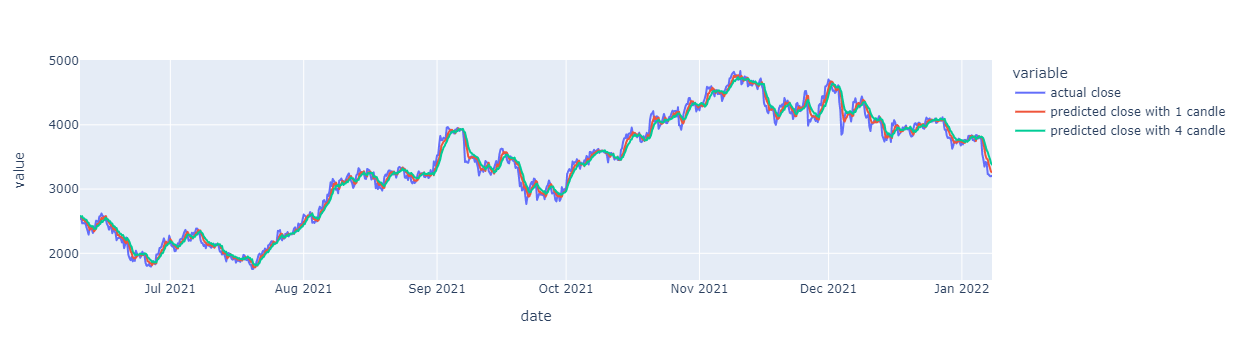

In [84]:
    import plotly.express as px
    import pandas as pd
    df = pd.read_csv('../Outputs/converted_date_ETHUSDT-6h-bitfinex/predictions.csv')
    df = df.drop(['Unnamed: 0'] , axis =1)
    fig = px.line(df, x = 'date', y = ['actual close','predicted close with 1 candle','predicted close with 4 candle'])
    fig.show()

In [ ]:
X_test_look_ahead = X_test_f.copy()
def change_value_next_value(i,j,predict):
    before = X_test_look_ahead[i,1:j,:]
    after = X_test_look_ahead[i,j+1:,:]
   
    before = before.reshape(-1)
    after = after.reshape(-1)
   
    before = np.append(before, predict)
    before = np.append(before, after)
    
    before = before.reshape(time_steps,1)
    
    X_test_look_ahead[i,:,:] = before
saeid =[]
# i = 0
for i in range(len(X_test_look_ahead)):
# for i in range(1):
    predict = model.predict((X_test_look_ahead[i,:,:]).reshape(1,X_test_look_ahead.shape[1], X_test_look_ahead.shape[2]))
    for k in range(look_ahead):
        i_hat = k + i
        if i_hat < len(X_test_look_ahead):
            change_value_next_value(i_hat, (len(X_test_look_ahead) - 1) - k, predict)
    saeid.append(predict)
print('done')